# Install Libraries

In [1]:
%pip install numpy
%pip install pandas
%pip install openpyxl
%pip install matplotlib
%pip install statsmodels
%pip install sklearn
%pip install prophet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import argparse
import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from prophet import Prophet

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Input Arguments

In [3]:
EXCEL_FILE_PATH = 'CBO EBO Revenue.xlsx'
OUTPUT_FILE_PATH = 'TruCast Output.xlsx'
MEDIUM_THRESHOLD = 200000 # in dollars
LARGE_THRESHOLD = 533000 # in dollars
NUMBER_OF_MONTHS = 12 # in months

# Functions

In [4]:
def fixed(revenue_series):
    return [revenue_series.iloc[-1]]*NUMBER_OF_MONTHS

def three_month(revenue_series):
    three_month_proj = pd.Series([revenue_series.iloc[-3], revenue_series.iloc[-2], revenue_series.iloc[-1]])
    for i in range(3, NUMBER_OF_MONTHS+3):
        number_of_non_nan_points = three_month_proj[i-3:].count()
        temp_series = three_month_proj.fillna(0)
        next_month = (temp_series.iloc[-3] + temp_series.iloc[-2] + temp_series.iloc[-1]) / number_of_non_nan_points
        three_month_proj = pd.concat([three_month_proj, pd.Series([next_month])], ignore_index=True)
    
    three_month_proj = three_month_proj[3:]
    return three_month_proj

def ARIMA_rolling_forcast_origin(revenue_series, number_of_predicted_months, p, q, d):
    # Preforms a rolling forcast origin for an using an arima model on times series data for a set number of number_of_predicted_months < len(revenue_series) 
    arima_revenue_projection_list = revenue_series.tolist()
    total_revenue_by_month_list = revenue_series.tolist()
    for index, revenue in enumerate(arima_revenue_projection_list):
        if len(arima_revenue_projection_list) - index < number_of_predicted_months:
            try:
                model = ARIMA(total_revenue_by_month_list[0:index], order=(p, d, q))
                try:
                    results = model.fit()
                    forecast = results.forecast(steps=1)
                except LinAlgError as e:
                    forecast = [-10000000]
                arima_revenue_projection_list[index] = forecast[0]
            except LinAlgError as e:
                arima_revenue_projection_list[index] = np.nan
                continue
    arima_revenue_projection = pd.Series(data=arima_revenue_projection_list, index=revenue_series.index)
    
    return arima_revenue_projection

def arima(revenue_series):
    # Train on 1/3 of the data
    number_of_predicted_months = int(len(revenue_series)/3)

    # Choose the range of p and q that you want to optmize over
    p_range = 4  #put 
    q_range = 4  #put 
    d = 1

    # Create an ARIMA model on the data for each value of p and q forcast it forward using a rolling origin forcast, determine which pair of p and q works
    # best and output that
    arima_revenue_projection_list = revenue_series.tolist()
    projection_percent_difference = {}
    for i in range(1, p_range):
        for ii in range(1, q_range):
            projection = ARIMA_rolling_forcast_origin(revenue_series, number_of_predicted_months, i, ii, d)

            percent_difference = abs(projection[-number_of_predicted_months:] - arima_revenue_projection_list[-number_of_predicted_months:]) / arima_revenue_projection_list[-number_of_predicted_months:] * 100
            projection_avg_percent_difference = percent_difference.mean()

            if projection_avg_percent_difference == np.nan:
                # If any errors occur set the percent error to really high so it doesn't get choosen
                projection_percent_difference[(i, ii)] = 1000
            else:
                projection_percent_difference[(i, ii)] = projection_avg_percent_difference

    min_error_key = min(projection_percent_difference, key=projection_percent_difference.get)
    p = min_error_key[0]
    q = min_error_key[1]

    # Use the ARIMA model that produced the minimum error and forcast 1 time step forward
    model = ARIMA(revenue_series, order=(p, d, q))
    results = model.fit()
    forecast = results.forecast(steps=NUMBER_OF_MONTHS)

    return forecast

def prophet(revenue_series):
    # for the model, make a dataframe with columns 'ds' and 'y' out of the hospital row, which was a Series
    curr_hospital = pd.DataFrame({'ds':revenue_series.index, 'y':revenue_series.values})

    # make the months datetime objects, and the revenues numbers
    curr_hospital['ds'] = pd.to_datetime(curr_hospital['ds'])
    curr_hospital['y'] = pd.to_numeric(curr_hospital['y'])

    # training on all revenues up to the last year (CAN BE MODIFIED TO BE THE LAST MONTH, TWO MONTHS, ETC.)
    # MUDIT COMMENT: JUST GOT RID OF THE "-NUMBER_OF_MONTHS" HERE, NOW TRAINING ON ALL DATA IN REVENUE_SERIES
    train = curr_hospital.iloc[:len(curr_hospital)]

    # testing how accurately we predict the last year (CAN BE MODIFIED TO BE THE LAST MONTH, TWO MONTHS, ETC.)
    test = curr_hospital.iloc[len(curr_hospital) - NUMBER_OF_MONTHS:]

    # if this row of the dataframe contains less than two non-nan values, we cannot predict on it — SKIP
    if train[train['y'].notnull()].shape[0] < 2:
        return None # WE SHOULD REDIRECT HERE TO ANOTHER MODEL, IF THERE IS NOT ENOUGH TRAINING DATA FOR PROPHET
    
    # fit the model, generate the forecast
    m = Prophet()
    m.fit(train)
    future = m.make_future_dataframe(periods = NUMBER_OF_MONTHS, freq='MS')
    forecast = m.predict(future)

    # generate predictions (contains all from 2004 through 2023)
    predictions = forecast[['ds', 'yhat']].set_index('ds')['yhat'].iloc[-NUMBER_OF_MONTHS:]
    predictions_lower = forecast[['ds', 'yhat_lower']].set_index('ds')['yhat_lower'].iloc[-NUMBER_OF_MONTHS:]
    predictions_upper = forecast[['ds', 'yhat_upper']].set_index('ds')['yhat_upper'].iloc[-NUMBER_OF_MONTHS:]
    
    output_columns = predictions.index

    # return a tuple of the lower, point estimate, and upper bound for the last month
    return (predictions.values, predictions_lower.values, predictions_upper.values)
    
def determine_projection_type(revenue_series, medium_threshold, large_threshold):
    THREE_MONTH_AVERAGE_DATA_CUTOFF = 6

    if (revenue_series.iloc[-2] == revenue_series.iloc[-1]) or (np.isnan(revenue_series.iloc[-1])):
        return 'fixed'
    elif revenue_series.iloc[-NUMBER_OF_MONTHS:].count() >= THREE_MONTH_AVERAGE_DATA_CUTOFF:
        # if there are less than 12 but more than 6 monthds of data, then find yearly revenue
        number_of_month_data_points = revenue_series.iloc[-NUMBER_OF_MONTHS:].count()
        yearly_revenue = (sum(revenue_series.iloc[-number_of_month_data_points:])/number_of_month_data_points)*12
    else:
        # if there isn't a years worth of data just return a 3 month average
        return 'three_month'
    #MODIFIED FOR TESTING
    if yearly_revenue > medium_threshold:
        return 'prophet'
    else:
        return 'prophet'
    
def rename_duplicates(names):
    name_count = {}
    modified_names = []

    for name in names:
        if name in name_count:
            name_count[name] += 1
        else:
            name_count[name] = 1

        if name_count[name] == 1:
            modified_names.append(name)
        else:
            modified_names.append(f"{name}_{name_count[name]-1}")

    return modified_names

# TruCast

In [5]:
if EXCEL_FILE_PATH.endswith('.xls') or EXCEL_FILE_PATH.endswith('.xlsx'):
    #revenue_data = pd.read_excel(EXCEL_FILE_PATH, index_col=['Site', 'Customer Code'])
    revenue_data = pd.read_excel(EXCEL_FILE_PATH, index_col='site')
else:
    print("Error: Input file must be in Excel format.")

# Create dataframe for the output date
new_months = list(pd.date_range(revenue_data.columns[-1], periods=NUMBER_OF_MONTHS+1, freq='M').strftime('%Y-%m'))[1:NUMBER_OF_MONTHS+1]
revenue_data.columns = [col.strftime('%Y-%m') if isinstance(col, pd.Timestamp) else col for col in revenue_data.columns]
column_names = list(revenue_data.columns) + new_months
revenue_data.index = rename_duplicates(revenue_data.index)
output_data = pd.DataFrame(index=revenue_data.index, columns=column_names)

hospital_model = {}

#Loop through hospitals
for hospital, revenue_series in revenue_data.iterrows():
    projection_type = determine_projection_type(revenue_series, MEDIUM_THRESHOLD, LARGE_THRESHOLD)
    # append hospitl and projection type to df
    hospital_model[hospital] = projection_type
    print(f'{hospital}: {projection_type}')
    if projection_type == 'fixed':
        projection = fixed(revenue_series)
    elif projection_type == 'three_month':
        projection = three_month(revenue_series)
    elif projection_type == 'arima':
        try:
            projection = arima(revenue_series)
        except:
            projection = three_month(revenue_series)
    elif projection_type == 'prophet':
        try:
            (projection, prophet_low, prophet_high) = prophet(revenue_series)
        except:
            projection = three_month(revenue_series)

    projection = [rev if rev >= 0 or np.isnan(rev) else 0 for rev in projection] # Sets a lower bound of 0 for any projection
    
    output_data.loc[hospital] = pd.concat([revenue_series, pd.Series(data=projection, index=new_months)])

output_data.dropna(inplace=True, how='all')
output_data.to_excel(OUTPUT_FILE_PATH, index_label='site')

hospital_model_df = pd.DataFrame(list(hospital_model.items()), columns=['Hospital', 'Model'])
input_file_name = EXCEL_FILE_PATH.split('/')[-1]
hospital_model_output_path =  'TruCast_Models_Used ' + input_file_name
hospital_model_df.to_excel(hospital_model_output_path, index_label='site')

display(output_data)

Abraham Lincoln: fixed
Acadia-St.Landry Hospital: prophet


16:55:05 - cmdstanpy - INFO - Chain [1] start processing
16:55:05 - cmdstanpy - INFO - Chain [1] done processing
16:55:05 - cmdstanpy - INFO - Chain [1] start processing
16:55:05 - cmdstanpy - INFO - Chain [1] done processing


Adirondack Medical Center: fixed
Alaska Native Tribal Health: prophet
Aleutian Pribilof Islands Association: prophet


16:55:06 - cmdstanpy - INFO - Chain [1] start processing
16:55:06 - cmdstanpy - INFO - Chain [1] done processing
16:55:06 - cmdstanpy - INFO - Chain [1] start processing


Allen Parish: prophet


16:55:06 - cmdstanpy - INFO - Chain [1] done processing
16:55:06 - cmdstanpy - INFO - Chain [1] start processing


American Behavioral Health Systems, Inc.: prophet


16:55:07 - cmdstanpy - INFO - Chain [1] done processing
16:55:07 - cmdstanpy - INFO - Chain [1] start processing


Arbuckle Memorial: fixed
Arizona General: fixed
Artesia General: prophet


16:55:07 - cmdstanpy - INFO - Chain [1] done processing
16:55:07 - cmdstanpy - INFO - Chain [1] start processing


Atchison Clinic: fixed
Atchison Hospital: prophet


16:55:08 - cmdstanpy - INFO - Chain [1] done processing
16:55:08 - cmdstanpy - INFO - Chain [1] start processing


BAYSIDE COMMUNITY CLINIC: prophet


16:55:08 - cmdstanpy - INFO - Chain [1] done processing
16:55:09 - cmdstanpy - INFO - Chain [1] start processing


BAYSIDE COMMUNITY HOSPITAL: prophet


16:55:09 - cmdstanpy - INFO - Chain [1] done processing
16:55:09 - cmdstanpy - INFO - Chain [1] start processing


BEAR VALLEY COMMUNITY HEALTHCARE: prophet


16:55:09 - cmdstanpy - INFO - Chain [1] done processing
16:55:10 - cmdstanpy - INFO - Chain [1] start processing


Barlow Respiratory Hospital: fixed
Bath Community Hospital: prophet


16:55:10 - cmdstanpy - INFO - Chain [1] done processing
16:55:10 - cmdstanpy - INFO - Chain [1] start processing


Big Sandy Medical Center: fixed
Big South Fork Medical Center: prophet


16:55:10 - cmdstanpy - INFO - Chain [1] done processing
16:55:10 - cmdstanpy - INFO - Chain [1] start processing


Black Hills Surgical: fixed
Boone Memorial: prophet


16:55:11 - cmdstanpy - INFO - Chain [1] done processing
16:55:11 - cmdstanpy - INFO - Chain [1] start processing


Bristow (CMOS): fixed
Brodstone: fixed
Brodstone Medicaid: fixed
Brownfield Regional: prophet


16:55:11 - cmdstanpy - INFO - Chain [1] done processing
16:55:11 - cmdstanpy - INFO - Chain [1] start processing


Buchanan Clinic: fixed
Buchanan General: prophet


16:55:12 - cmdstanpy - INFO - Chain [1] done processing
16:55:12 - cmdstanpy - INFO - Chain [1] start processing


Buchanan Surgical Clinic: fixed
Buchanan Tri-State Clinic: prophet


16:55:12 - cmdstanpy - INFO - Chain [1] done processing
16:55:12 - cmdstanpy - INFO - Chain [1] start processing


Burke Hospital: prophet


16:55:12 - cmdstanpy - INFO - Chain [1] done processing
16:55:13 - cmdstanpy - INFO - Chain [1] start processing


CHC Community Care: prophet


16:55:13 - cmdstanpy - INFO - Chain [1] done processing
16:55:13 - cmdstanpy - INFO - Chain [1] start processing


Caldwell: fixed
Caldwell - ARMS Clinic: fixed
Caldwell - IFS: fixed
Calhoun Liberty Hospital: prophet


16:55:13 - cmdstanpy - INFO - Chain [1] done processing
16:55:13 - cmdstanpy - INFO - Chain [1] start processing


Cascade: fixed
Cedar County: prophet


16:55:13 - cmdstanpy - INFO - Chain [1] done processing


Cedar Lake Nursing Home: three_month
Childress Regional: prophet


16:55:14 - cmdstanpy - INFO - Chain [1] start processing
16:55:14 - cmdstanpy - INFO - Chain [1] done processing
16:55:14 - cmdstanpy - INFO - Chain [1] start processing


Christus Health: prophet


16:55:14 - cmdstanpy - INFO - Chain [1] done processing
16:55:15 - cmdstanpy - INFO - Chain [1] start processing


City Hospital: fixed
Claiborne County: prophet


16:55:15 - cmdstanpy - INFO - Chain [1] done processing
16:55:15 - cmdstanpy - INFO - Chain [1] start processing


Clifton Fine: fixed
Clinch Memorial Hospital: prophet


16:55:15 - cmdstanpy - INFO - Chain [1] done processing
16:55:15 - cmdstanpy - INFO - Chain [1] start processing


Coal County: prophet


16:55:16 - cmdstanpy - INFO - Chain [1] done processing
16:55:16 - cmdstanpy - INFO - Chain [1] start processing


Coal County (Clinic): prophet


16:55:16 - cmdstanpy - INFO - Chain [1] done processing
16:55:16 - cmdstanpy - INFO - Chain [1] start processing


Columbia Surgical Specialists, P.S: fixed
Columbus Specialty: prophet


16:55:16 - cmdstanpy - INFO - Chain [1] done processing
16:55:17 - cmdstanpy - INFO - Chain [1] start processing


Community Hospital: prophet


16:55:17 - cmdstanpy - INFO - Chain [1] done processing
16:55:17 - cmdstanpy - INFO - Chain [1] start processing
16:55:17 - cmdstanpy - INFO - Chain [1] done processing


Confederated Tribe of Siletz Indians: prophet
Coosa Valley Medical Center - Clinic: prophet


16:55:17 - cmdstanpy - INFO - Chain [1] start processing
16:55:17 - cmdstanpy - INFO - Chain [1] done processing
16:55:17 - cmdstanpy - INFO - Chain [1] start processing


Coosa Valley Medical Center - Hospital: prophet


16:55:18 - cmdstanpy - INFO - Chain [1] done processing
16:55:18 - cmdstanpy - INFO - Chain [1] start processing
16:55:18 - cmdstanpy - INFO - Chain [1] done processing


Copely Hospital: prophet


16:55:18 - cmdstanpy - INFO - Chain [1] start processing
16:55:18 - cmdstanpy - INFO - Chain [1] done processing


Copper River Native Association: prophet


16:55:18 - cmdstanpy - INFO - Chain [1] start processing


Covington County: prophet


16:55:19 - cmdstanpy - INFO - Chain [1] done processing
16:55:19 - cmdstanpy - INFO - Chain [1] start processing


Crenshaw Clinic: prophet


16:55:19 - cmdstanpy - INFO - Chain [1] done processing
16:55:19 - cmdstanpy - INFO - Chain [1] start processing


Crenshaw Community: prophet


16:55:19 - cmdstanpy - INFO - Chain [1] done processing
16:55:19 - cmdstanpy - INFO - Chain [1] start processing


Crook County: prophet


16:55:20 - cmdstanpy - INFO - Chain [1] done processing
16:55:20 - cmdstanpy - INFO - Chain [1] start processing


Cumberland County: prophet


16:55:20 - cmdstanpy - INFO - Chain [1] done processing
16:55:20 - cmdstanpy - INFO - Chain [1] start processing
16:55:20 - cmdstanpy - INFO - Chain [1] done processing


Cumberland River: fixed
Curry General: prophet
DeSoto Clinic: prophet


16:55:21 - cmdstanpy - INFO - Chain [1] start processing
16:55:21 - cmdstanpy - INFO - Chain [1] done processing
16:55:21 - cmdstanpy - INFO - Chain [1] start processing


DeSoto Regional: prophet


16:55:21 - cmdstanpy - INFO - Chain [1] done processing
16:55:22 - cmdstanpy - INFO - Chain [1] start processing
16:55:22 - cmdstanpy - INFO - Chain [1] done processing


Decatur County: prophet


16:55:22 - cmdstanpy - INFO - Chain [1] start processing


Divine Savior: fixed
Drew Memorial Hospital: prophet


16:55:22 - cmdstanpy - INFO - Chain [1] done processing
16:55:22 - cmdstanpy - INFO - Chain [1] start processing


East Mesa: fixed
El Campo Memorial Hospital: prophet


16:55:22 - cmdstanpy - INFO - Chain [1] done processing
16:55:22 - cmdstanpy - INFO - Chain [1] start processing


El Llano: fixed
Electra Hospital: fixed
Elkview General Hospital: fixed
Erlanger W Carolina Hospital: fixed
Escambia County: prophet


16:55:23 - cmdstanpy - INFO - Chain [1] done processing
16:55:23 - cmdstanpy - INFO - Chain [1] start processing


Escambia County_1: prophet


16:55:23 - cmdstanpy - INFO - Chain [1] done processing
16:55:23 - cmdstanpy - INFO - Chain [1] start processing
16:55:23 - cmdstanpy - INFO - Chain [1] done processing


Evergreen Medical Center: prophet


16:55:23 - cmdstanpy - INFO - Chain [1] start processing


Excelsior Springs: prophet


16:55:24 - cmdstanpy - INFO - Chain [1] done processing
16:55:24 - cmdstanpy - INFO - Chain [1] start processing


FLINT RIVER: prophet


16:55:24 - cmdstanpy - INFO - Chain [1] done processing
16:55:24 - cmdstanpy - INFO - Chain [1] start processing
16:55:25 - cmdstanpy - INFO - Chain [1] done processing


Faith Community Hospital: fixed
Fallon Medical Complex: fixed
Ferry County Public Hospital District: prophet


16:55:25 - cmdstanpy - INFO - Chain [1] start processing


Fisher County: fixed
Fisher County Hospital District: three_month
Fountain Hills: fixed
Frio Regional: prophet


16:55:25 - cmdstanpy - INFO - Chain [1] done processing
16:55:25 - cmdstanpy - INFO - Chain [1] start processing
16:55:25 - cmdstanpy - INFO - Chain [1] done processing


GREENE COUNTY GENERAL HOSPITAL: fixed
Garfield County Hospital District: prophet


16:55:25 - cmdstanpy - INFO - Chain [1] start processing
16:55:25 - cmdstanpy - INFO - Chain [1] done processing


George E. Weems: prophet
Gifford Healthcare: fixed
Grove Hill Memorial Hospital: prophet


16:55:25 - cmdstanpy - INFO - Chain [1] start processing
16:55:26 - cmdstanpy - INFO - Chain [1] done processing
16:55:26 - cmdstanpy - INFO - Chain [1] start processing
16:55:26 - cmdstanpy - INFO - Chain [1] done processing


Harbor Regional Health: three_month
Hardtner Medical Center: fixed
Healdsburg District Hospital: prophet


16:55:26 - cmdstanpy - INFO - Chain [1] start processing


Henderson County: prophet


16:55:26 - cmdstanpy - INFO - Chain [1] done processing
16:55:26 - cmdstanpy - INFO - Chain [1] start processing


Henry County: fixed
Herington Hospital: fixed
Hiawatha: prophet


16:55:27 - cmdstanpy - INFO - Chain [1] done processing
16:55:27 - cmdstanpy - INFO - Chain [1] start processing


Highland: fixed
Holy Cross Clinic: prophet


16:55:27 - cmdstanpy - INFO - Chain [1] done processing
16:55:27 - cmdstanpy - INFO - Chain [1] start processing


Holy Cross Hospital: prophet


16:55:28 - cmdstanpy - INFO - Chain [1] done processing
16:55:28 - cmdstanpy - INFO - Chain [1] start processing
16:55:28 - cmdstanpy - INFO - Chain [1] done processing


Houston County: fixed
Huggins (ARMS): fixed
Huggins ARMS: prophet


16:55:28 - cmdstanpy - INFO - Chain [1] start processing
16:55:28 - cmdstanpy - INFO - Chain [1] done processing


Huggins CMOS: fixed
Huron Regional: fixed
Institute for Orthopaedic Surgery: fixed
Iroquois Memorial Hospital: prophet


16:55:28 - cmdstanpy - INFO - Chain [1] start processing
16:55:28 - cmdstanpy - INFO - Chain [1] done processing


J. Arthur Doser: prophet


16:55:29 - cmdstanpy - INFO - Chain [1] start processing


Jackson Hospital & Clinics: fixed
Jackson Medical AL: prophet


16:55:29 - cmdstanpy - INFO - Chain [1] done processing
16:55:29 - cmdstanpy - INFO - Chain [1] start processing


Jefferson Hospital: prophet


16:55:29 - cmdstanpy - INFO - Chain [1] done processing
16:55:29 - cmdstanpy - INFO - Chain [1] start processing


Jenkins County: prophet


16:55:30 - cmdstanpy - INFO - Chain [1] done processing
16:55:30 - cmdstanpy - INFO - Chain [1] start processing


Jennie Stuart Medical Center: prophet


16:55:30 - cmdstanpy - INFO - Chain [1] done processing
16:55:30 - cmdstanpy - INFO - Chain [1] start processing
16:55:30 - cmdstanpy - INFO - Chain [1] done processing


Jersey CMOS: fixed
John C. Fremont Healthcare District: prophet


16:55:31 - cmdstanpy - INFO - Chain [1] start processing


KANSAS SURGERY AND RECOVERY CENTER: prophet


16:55:31 - cmdstanpy - INFO - Chain [1] done processing
16:55:31 - cmdstanpy - INFO - Chain [1] start processing


KH - Philadelphia: prophet


16:55:32 - cmdstanpy - INFO - Chain [1] done processing
16:55:32 - cmdstanpy - INFO - Chain [1] start processing
16:55:32 - cmdstanpy - INFO - Chain [1] done processing


Kalispel Tribe of Indians: prophet


16:55:32 - cmdstanpy - INFO - Chain [1] start processing
16:55:32 - cmdstanpy - INFO - Chain [1] done processing


Kenaitze Indian Tribe: prophet


16:55:32 - cmdstanpy - INFO - Chain [1] start processing


Kimball Health Services: prophet


16:55:32 - cmdstanpy - INFO - Chain [1] done processing
16:55:33 - cmdstanpy - INFO - Chain [1] start processing


Kimball Health Services (Clinic): prophet


16:55:33 - cmdstanpy - INFO - Chain [1] done processing
16:55:33 - cmdstanpy - INFO - Chain [1] start processing


Kiowa City: prophet


16:55:33 - cmdstanpy - INFO - Chain [1] done processing
16:55:33 - cmdstanpy - INFO - Chain [1] start processing


Kit Carson Clinic: prophet


16:55:33 - cmdstanpy - INFO - Chain [1] done processing
16:55:34 - cmdstanpy - INFO - Chain [1] start processing


Kit Carson County Memorial Hospital: prophet


16:55:34 - cmdstanpy - INFO - Chain [1] done processing
16:55:34 - cmdstanpy - INFO - Chain [1] start processing
16:55:34 - cmdstanpy - INFO - Chain [1] done processing


Kodiak Area Native Association: fixed
LABETTE HEALTH: fixed
La Paz (PE): prophet
LaSalle General Hospital: prophet


16:55:34 - cmdstanpy - INFO - Chain [1] start processing
16:55:34 - cmdstanpy - INFO - Chain [1] done processing
16:55:34 - cmdstanpy - INFO - Chain [1] start processing
16:55:34 - cmdstanpy - INFO - Chain [1] done processing


Lamar Healthcare: prophet
Lee Carlson: prophet


16:55:35 - cmdstanpy - INFO - Chain [1] start processing
16:55:35 - cmdstanpy - INFO - Chain [1] done processing
16:55:35 - cmdstanpy - INFO - Chain [1] start processing
16:55:35 - cmdstanpy - INFO - Chain [1] done processing


Legent Hospital for Special Surgery: prophet
Legent Northwest Houston: prophet


16:55:35 - cmdstanpy - INFO - Chain [1] start processing
16:55:35 - cmdstanpy - INFO - Chain [1] done processing
16:55:35 - cmdstanpy - INFO - Chain [1] start processing
16:55:35 - cmdstanpy - INFO - Chain [1] done processing


Legent Orthopedic Hospital: prophet
Legent Orthopedic and Spine: prophet


16:55:35 - cmdstanpy - INFO - Chain [1] start processing
16:55:35 - cmdstanpy - INFO - Chain [1] done processing
16:55:35 - cmdstanpy - INFO - Chain [1] start processing


Liberty Regional: prophet


16:55:36 - cmdstanpy - INFO - Chain [1] done processing
16:55:36 - cmdstanpy - INFO - Chain [1] start processing


Lincoln Community Hospital & NH: prophet


16:55:36 - cmdstanpy - INFO - Chain [1] done processing
16:55:36 - cmdstanpy - INFO - Chain [1] start processing
16:55:36 - cmdstanpy - INFO - Chain [1] done processing


Lincoln Glen Skilled Nursing Care: three_month
Lynn County: prophet
MCBRIDE ORTHOPEDIC HOSPITAL: prophet


16:55:36 - cmdstanpy - INFO - Chain [1] start processing
16:55:37 - cmdstanpy - INFO - Chain [1] done processing
16:55:37 - cmdstanpy - INFO - Chain [1] start processing
16:55:37 - cmdstanpy - INFO - Chain [1] done processing


Madelia Community: prophet
Madelia Community_1: prophet


16:55:37 - cmdstanpy - INFO - Chain [1] start processing
16:55:37 - cmdstanpy - INFO - Chain [1] done processing
16:55:37 - cmdstanpy - INFO - Chain [1] start processing


Magee Rehab: fixed
Martin County Hospital District: prophet


16:55:37 - cmdstanpy - INFO - Chain [1] done processing
16:55:37 - cmdstanpy - INFO - Chain [1] start processing
16:55:38 - cmdstanpy - INFO - Chain [1] done processing


Medina Memorial Hospital: fixed
Memoria Hospital Seminole: fixed
Mercy Joplin: fixed
Michigan Orthopedic Center: fixed
Mid Coast -Brunswick: fixed
Mid Coast Bellville: three_month
Mid Coast Llano: prophet
Millinocket: prophet


16:55:38 - cmdstanpy - INFO - Chain [1] start processing
16:55:38 - cmdstanpy - INFO - Chain [1] done processing
16:55:38 - cmdstanpy - INFO - Chain [1] start processing
16:55:38 - cmdstanpy - INFO - Chain [1] done processing


Mitchell County Hospital: fixed
Mitias Orthopaedics: fixed
Moab Regional: fixed
Modoc Medical Center: prophet
Monroe (AL): prophet


16:55:38 - cmdstanpy - INFO - Chain [1] start processing
16:55:38 - cmdstanpy - INFO - Chain [1] done processing
16:55:39 - cmdstanpy - INFO - Chain [1] start processing
16:55:39 - cmdstanpy - INFO - Chain [1] done processing


Morris County: fixed
Mount Sanford Tribal Consortium: fixed
Mountainvew Medical Center: fixed
Mt. Desert Island: fixed
Muenster Memorial Hospital: prophet
Nevada Regional: fixed
Niobrara Valley: prophet


16:55:39 - cmdstanpy - INFO - Chain [1] start processing
16:55:39 - cmdstanpy - INFO - Chain [1] done processing
16:55:39 - cmdstanpy - INFO - Chain [1] start processing
16:55:39 - cmdstanpy - INFO - Chain [1] done processing


Noncona General: prophet
North Runnels: prophet


16:55:39 - cmdstanpy - INFO - Chain [1] start processing
16:55:39 - cmdstanpy - INFO - Chain [1] done processing
16:55:39 - cmdstanpy - INFO - Chain [1] start processing


Northern Rockies: prophet


16:55:40 - cmdstanpy - INFO - Chain [1] done processing
16:55:40 - cmdstanpy - INFO - Chain [1] start processing
16:55:40 - cmdstanpy - INFO - Chain [1] done processing


Ocean Beach Hospital and Medical Clinics: prophet
Ochiltree: prophet


16:55:40 - cmdstanpy - INFO - Chain [1] start processing
16:55:40 - cmdstanpy - INFO - Chain [1] done processing
16:55:41 - cmdstanpy - INFO - Chain [1] start processing


Ohio Valley Surgical Hospital: prophet


16:55:41 - cmdstanpy - INFO - Chain [1] done processing
16:55:41 - cmdstanpy - INFO - Chain [1] start processing


Omega Hospital: three_month
Optim Healthcare: fixed
PONDERA MEDICAL CENTER: prophet


16:55:41 - cmdstanpy - INFO - Chain [1] done processing
16:55:41 - cmdstanpy - INFO - Chain [1] start processing


PREMIER SURGICAL INSTITUTE: fixed
PSN Services: fixed
Palacios Community Medical Center: prophet


16:55:42 - cmdstanpy - INFO - Chain [1] done processing
16:55:42 - cmdstanpy - INFO - Chain [1] start processing
16:55:42 - cmdstanpy - INFO - Chain [1] done processing


Parkview: fixed
Paul's Valley: fixed
Pecos County Memorial Hospital: prophet
Perkins County: prophet


16:55:42 - cmdstanpy - INFO - Chain [1] start processing
16:55:42 - cmdstanpy - INFO - Chain [1] done processing
16:55:42 - cmdstanpy - INFO - Chain [1] start processing


Petersburg Medical Center: prophet


16:55:52 - cmdstanpy - INFO - Chain [1] done processing
16:55:52 - cmdstanpy - INFO - Chain [1] start processing


Physicians: fixed
Pineville Community: prophet


16:55:52 - cmdstanpy - INFO - Chain [1] done processing
16:55:52 - cmdstanpy - INFO - Chain [1] start processing


Pioneer Medical Center: fixed
Pomerene: fixed
Pomerene Hospital: three_month
Pondera Clinic: prophet


16:55:52 - cmdstanpy - INFO - Chain [1] done processing
16:55:53 - cmdstanpy - INFO - Chain [1] start processing


Pratt Medicare & Commercial: prophet


16:55:53 - cmdstanpy - INFO - Chain [1] done processing
16:55:53 - cmdstanpy - INFO - Chain [1] start processing
16:55:53 - cmdstanpy - INFO - Chain [1] done processing


Promise Healthcare (Facility): fixed
Prosser Memorial: prophet


16:55:53 - cmdstanpy - INFO - Chain [1] start processing


Prosser Memorial_1: prophet


16:55:53 - cmdstanpy - INFO - Chain [1] done processing
16:55:54 - cmdstanpy - INFO - Chain [1] start processing


Providence Medical Group: fixed
Pulaski Memorial: three_month
REAGAN MEMORIAL HOSPITAL: prophet


16:55:54 - cmdstanpy - INFO - Chain [1] done processing
16:55:54 - cmdstanpy - INFO - Chain [1] start processing
16:55:54 - cmdstanpy - INFO - Chain [1] done processing


RHS of Howard: prophet


16:55:55 - cmdstanpy - INFO - Chain [1] start processing


Resilient Healthcare: fixed
Richland Clinic: prophet


16:55:55 - cmdstanpy - INFO - Chain [1] done processing
16:55:55 - cmdstanpy - INFO - Chain [1] start processing
16:55:55 - cmdstanpy - INFO - Chain [1] done processing


Roger Mills: fixed
Rolling Plains (PE): prophet


16:55:55 - cmdstanpy - INFO - Chain [1] start processing


Rolling Plains Hospital: prophet


16:55:55 - cmdstanpy - INFO - Chain [1] done processing
16:55:55 - cmdstanpy - INFO - Chain [1] start processing


Ruby Valley: fixed
SHARKEY-ISSAQUENA COMMUNITY HOSPITAL: prophet


16:55:56 - cmdstanpy - INFO - Chain [1] done processing
16:55:56 - cmdstanpy - INFO - Chain [1] start processing
16:55:56 - cmdstanpy - INFO - Chain [1] done processing


SMP St. Aloisuis: prophet


16:55:56 - cmdstanpy - INFO - Chain [1] start processing
16:55:56 - cmdstanpy - INFO - Chain [1] done processing


Salem: fixed
Salt River Pima-Maricopa Indian Community: prophet


16:55:56 - cmdstanpy - INFO - Chain [1] start processing
16:55:56 - cmdstanpy - INFO - Chain [1] done processing


San Bernardino: fixed
Santa Cruz Valley Regional: fixed
Saunders Medical: fixed
Savoy Medical: three_month
Seminole Hospital: prophet


16:55:56 - cmdstanpy - INFO - Chain [1] start processing
16:55:57 - cmdstanpy - INFO - Chain [1] done processing


Seneca Healthcare District: prophet


16:55:57 - cmdstanpy - INFO - Chain [1] start processing


Share Medical: prophet


16:55:57 - cmdstanpy - INFO - Chain [1] done processing
16:55:57 - cmdstanpy - INFO - Chain [1] start processing
16:55:57 - cmdstanpy - INFO - Chain [1] done processing


Sheridan Community: prophet


16:55:57 - cmdstanpy - INFO - Chain [1] start processing


Sistersville General Clinic: fixed
Sistersville General Hospital: fixed
Snoqualmie: prophet


16:55:57 - cmdstanpy - INFO - Chain [1] done processing
16:55:58 - cmdstanpy - INFO - Chain [1] start processing


South Cameron Memorial: fixed
Southern Coos Hospital: prophet


16:55:58 - cmdstanpy - INFO - Chain [1] done processing
16:55:58 - cmdstanpy - INFO - Chain [1] start processing
16:55:58 - cmdstanpy - INFO - Chain [1] done processing


Southern Humboldt Community Healthcare District: prophet
Southern Ohio: fixed
Southern Plains: fixed
Southern Plains ASC: fixed
Southlight: fixed
St. Helena Parish Hospital: prophet


16:55:58 - cmdstanpy - INFO - Chain [1] start processing
16:55:58 - cmdstanpy - INFO - Chain [1] done processing
16:55:58 - cmdstanpy - INFO - Chain [1] start processing


St. James Parish: fixed
Summer Meadows: fixed
Surgeons Choice Medical Center: prophet


16:55:59 - cmdstanpy - INFO - Chain [1] done processing
16:55:59 - cmdstanpy - INFO - Chain [1] start processing


Sweetwater Hospital: three_month
TRIGG: prophet


16:55:59 - cmdstanpy - INFO - Chain [1] done processing
16:55:59 - cmdstanpy - INFO - Chain [1] start processing


TRIGG CLINIC: prophet


16:55:59 - cmdstanpy - INFO - Chain [1] done processing
16:56:00 - cmdstanpy - INFO - Chain [1] start processing
16:56:00 - cmdstanpy - INFO - Chain [1] done processing


Taylorville: fixed
Taylorville Memorial: fixed
Texas Institute: prophet


16:56:00 - cmdstanpy - INFO - Chain [1] start processing


The Queens Health System: fixed
Throckmorton County: prophet


16:56:00 - cmdstanpy - INFO - Chain [1] done processing
16:56:00 - cmdstanpy - INFO - Chain [1] start processing
16:56:00 - cmdstanpy - INFO - Chain [1] done processing


Titus Regional (Clinic): fixed
Titus Regional (EMS): fixed
Titus Regional (Hospital): fixed
Trinity (LA): prophet


16:56:00 - cmdstanpy - INFO - Chain [1] start processing
16:56:00 - cmdstanpy - INFO - Chain [1] done processing


Trinity Medical: prophet
Trinity Memorial (El Campo): fixed
Trinity Twin - Two Cities: prophet


16:56:01 - cmdstanpy - INFO - Chain [1] start processing
16:56:01 - cmdstanpy - INFO - Chain [1] done processing
16:56:01 - cmdstanpy - INFO - Chain [1] start processing


Trinity Twin - Two Cities (Clinic): prophet


16:56:01 - cmdstanpy - INFO - Chain [1] done processing
16:56:01 - cmdstanpy - INFO - Chain [1] start processing
16:56:01 - cmdstanpy - INFO - Chain [1] done processing


Tyler County: prophet
Tyrone Hospital: fixed
ULP: prophet


16:56:01 - cmdstanpy - INFO - Chain [1] start processing
16:56:02 - cmdstanpy - INFO - Chain [1] done processing
16:56:02 - cmdstanpy - INFO - Chain [1] start processing
16:56:02 - cmdstanpy - INFO - Chain [1] done processing


United Surgical Partners International: fixed
Universal Behavioral Health: prophet
University Louisville Physicians - AMG: fixed
University Louisville Physicians - CMG: fixed
University of Vermont - Elizabethtown: fixed
WABASH GENERAL HOSPITAL: prophet


16:56:02 - cmdstanpy - INFO - Chain [1] start processing
16:56:02 - cmdstanpy - INFO - Chain [1] done processing
16:56:02 - cmdstanpy - INFO - Chain [1] start processing


WASHINGTON COUNTY HOSPITAL & NURSING HOME: prophet


16:56:02 - cmdstanpy - INFO - Chain [1] done processing
16:56:03 - cmdstanpy - INFO - Chain [1] start processing


WEST FELICIANA PARISH HOSPITAL: prophet


16:56:03 - cmdstanpy - INFO - Chain [1] done processing
16:56:03 - cmdstanpy - INFO - Chain [1] start processing


Wahiawa General: prophet


16:56:03 - cmdstanpy - INFO - Chain [1] done processing
16:56:03 - cmdstanpy - INFO - Chain [1] start processing
16:56:03 - cmdstanpy - INFO - Chain [1] done processing


Ward Memorial Hospital: prophet
Washoe Tribal Health: prophet


16:56:04 - cmdstanpy - INFO - Chain [1] start processing
16:56:04 - cmdstanpy - INFO - Chain [1] done processing
16:56:04 - cmdstanpy - INFO - Chain [1] start processing


Weatherford Regional Hospital: prophet


16:56:04 - cmdstanpy - INFO - Chain [1] done processing
16:56:04 - cmdstanpy - INFO - Chain [1] start processing


West Holt: fixed
West River: fixed
White County: fixed
Whitfield: prophet


16:56:04 - cmdstanpy - INFO - Chain [1] done processing
16:56:04 - cmdstanpy - INFO - Chain [1] start processing
16:56:04 - cmdstanpy - INFO - Chain [1] done processing


Wickenburg: fixed
Wyckoff Heights: prophet
Yakutat Community Health Center: fixed


,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,...,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12
Abraham Lincoln,16865.0,18965.0,22201.0,27864.0,20430.0,25328.0,20897.0,17417.0,53978.0,31801.0,...,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0
Acadia-St.Landry Hospital,47335.0,47151.0,71127.0,55330.0,53569.0,90612.0,50765.0,53116.0,48687.0,32288.0,...,56049.557619,33564.541479,13071.932108,70506.064874,31413.138472,34146.006918,49494.909851,12069.627941,31519.652525,36652.052126
Adirondack Medical Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alaska Native Tribal Health,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5745.486232,6299.272714,6835.195116,7388.981599,7924.904001,8478.690483,9032.476965,9568.399367,10122.185849,10658.108252
Aleutian Pribilof Islands Association,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7305.21253,6925.377601,6557.795413,6177.960485,5810.378296,5430.543368,5050.70844,4683.126251,4303.291323,3935.709134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
White County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0
Whitfield,94627.0,101402.0,118869.0,76170.0,59028.0,81497.0,55435.0,80986.0,85755.0,99483.0,...,123849.278663,84796.54428,56431.134714,107815.499237,64833.768996,94163.686917,97783.935751,106033.561816,90110.313056,73044.890755
Wickenburg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000.0,6000.0,6000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wyckoff Heights,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7339.414414,7045.776552,6761.610878,6467.973015,6183.807342,5890.169479,5596.531616,5312.365943,5018.72808,4734.562407


# Plot the Data

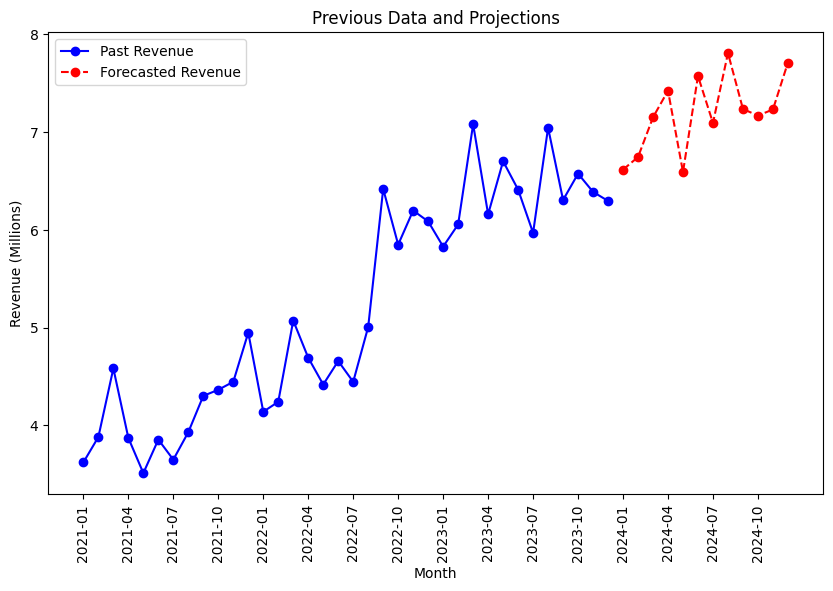

In [6]:
plt.figure(figsize=(10, 6))

# Adjust the data by dividing by 1 million to convert to millions
past_revenue = output_data.sum().values[0:-NUMBER_OF_MONTHS] / 1e6
forecasted_revenue = output_data.sum().values[-NUMBER_OF_MONTHS:] / 1e6

# Plotting the past revenue
plt.plot(output_data.columns[0:-NUMBER_OF_MONTHS], past_revenue, color='blue', marker='o', linestyle='-', label='Past Revenue')
# Plotting the forecasted revenue
plt.plot(output_data.columns[-NUMBER_OF_MONTHS:], forecasted_revenue, color='red', marker='o', linestyle='--', label='Forecasted Revenue')

plt.title('Previous Data and Projections')
plt.xlabel('Month')
plt.ylabel('Revenue (Millions)')
plt.xticks(output_data.columns[0::3], rotation=90)  # Adjust x-axis ticks

# Adding the legend to the plot
plt.legend()

# Show the plot
plt.show()